# Genetic Variant Classification
The presence of conflicting classifications among genetic variants in ClinVar presents a significant challenge for accurate interpretation by clinicians and researchers. This study addresses this issue by developing a predictive model to differentiate variants with conflicting classifications from those with consistent classifications. Leveraging a dataset containing annotations on human genetic variants, the 'CLASS' target variable denotes the presence (1) or absence (0) of conflicting classifications. Through the utilization of four classifier models (RandomForest, KNN, Decision Tree, logistic regression), trained and evaluated based on metrics such as accuracy and F1-score, the study aims to identify the best-performing algorithm to improve variant interpretation in both clinical and research settings.

The Dataset for this File is taken from https://www.kaggle.com/datasets/kevinarvai/clinvar-conflicting

## Approach
- **Data Exploration**: The dataset, obtained from Kaggle and originating from ClinVar, is explored to understand its structure, features, and target variable distribution.</br>
- **Data Preprocessing**: Preprocessing steps are performed to handle missing values, encode categorical variables, and prepare features for model training.</br>
- **Model Selection**: Four classifier models—K-Nearest Neighbors (KNN), Random Forest, Logistic Regression and Decision Tree-are selected to predict conflicting classifications. Each model is trained, evaluated, and compared based on performance metrics.</br>
- **Model Evaluation**: Model performance is assessed using metrics such as accuracy, precision, recall, and F1-score. Confusion matrices are analyzed to understand the models' predictive capabilities.
- **Model Optimization**: Hyperparameter tuning techniques, such as grid search or random search, are applied to optimize the selected models for improved performance.</br>
- **Final Model Selection**: Based on evaluation results, the best-performing algorithm is identified to accurately predict the presence of conflicting classifications in ClinVar variants, facilitating informed decision-making in clinical and research settings.

In [1]:
#Importing all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score

# Mute the sklearn and IPython warnings
import warnings
warnings.filterwarnings('ignore', module='sklearn')
warnings.filterwarnings('ignore', module='IPython')

In [2]:
data = pd.read_csv('./clinvar_dataset.csv', sep=',')
data.head()

C:\Users\hnnai\AppData\Local\Temp\ipykernel_22848\2729238830.py:1: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./clinvar_dataset.csv', sep=',')


,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [3]:
data.shape

(65188, 46)

In [4]:
data.CLASS.value_counts()

0    48754
1    16434
Name: CLASS, dtype: int64

We have a significantly higher number of consistent classifications, almost three time more compared to conflicting ones.

In [5]:
unique = []
for col in data.columns:
    unique.append((col, len(data[col].unique())))
unique_values = pd.DataFrame(unique, columns=['Features', 'Unique Values'])
unique_values

,Features,Unique Values
0,CHROM,38
1,POS,63115
2,REF,866
3,ALT,458
4,AF_ESP,2842
5,AF_EXAC,6667
6,AF_TGP,2087
7,CLNDISDB,9234
8,CLNDISDBINCL,94
9,CLNDN,9260


We're removing variables from the dataset that have over 4000 unique values because they might not contribute significantly to predictive accuracy and could potentially add unnecessary complexity to the model.

In [6]:
# Drop variables with more than 3500 unique values
to_drop = unique_values[unique_values['Unique Values'] > 4000]['Features']
data.drop(to_drop, axis=1, inplace=True)

# Create DataFrame showing remaining variable names and their unique values
unique_values_remaining = []
for column in data.columns:
    unique_values_remaining.append((column, len(data[column].unique())))
df_remaining_unique = pd.DataFrame(unique_values_remaining, columns=['Feature', 'Unique Values'])
print("Feeatures with less than 3500 unique values : ")
df_remaining_unique

Feeatures with less than 3500 unique values : 


,Feature,Unique Values
0,CHROM,38
1,REF,866
2,ALT,458
3,AF_ESP,2842
4,AF_TGP,2087
5,CLNDISDBINCL,94
6,CLNDNINCL,102
7,CLNSIGINCL,138
8,CLNVC,7
9,MC,91


## Featureset Exploration
In our exploration of dataset features, we aim to assess their significance and completeness. Notable features we'll examine include:
- CHROM: Identifies the chromosome of variant location.
- REF: Represents the reference allele.
- ALT: Denotes the alternate allele.
- AF_ESP: Indicates allele frequencies sourced from GO-ESP.
- AF_EXAC: Illustrates allele frequencies obtained from ExAC.
- AF_TGP: Reflects allele frequencies derived from the 1000 Genomes Project.
- CLNDISDB: Contains disease database names and associated identifiers (e.g., OMIM:NNNNNN).
- CLNDISDBINCL: Includes disease database names and identifiers for specific variants (e.g., OMIM:NN).
- CLNDN: Displays ClinVar's preferred disease names linked to identifiers in CLNDISDB.
- IMPACT: Describes the impact modifier associated with the consequence type.
- MOTIF_SCORE_CHANGE: Indicates the difference in motif scores between the reference and variant sequences for the Transcription Factor Binding Protein (TFBP).

In [7]:
num_missing = data.isnull().sum()
percentage_missing = data.isnull().sum().apply(lambda x: x/data.shape[0]*100)

In [8]:
missing_data = pd.DataFrame({'Number of Missing':  num_missing,'Percentage of Missing': percentage_missing})
missing_data.sort_values(by='Percentage of Missing', ascending=False)

,Number of Missing,Percentage of Missing
MOTIF_NAME,65186,99.996932
MOTIF_SCORE_CHANGE,65186,99.996932
HIGH_INF_POS,65186,99.996932
MOTIF_POS,65186,99.996932
DISTANCE,65080,99.834325
SSR,65058,99.800577
CLNDISDBINCL,65021,99.743818
CLNDNINCL,65021,99.743818
CLNSIGINCL,65021,99.743818
INTRON,56385,86.495981


We're excluding columns with over 30% missing data to enhance the reliability and quality of our analysis. Features with substantial missing data may not offer valuable insights and could potentially skew our models. By removing such columns, we prioritize analyzing more informative and complete data, thereby improving the accuracy of our results.

In [9]:
drop_list = list(missing_data[missing_data['Percentage of Missing'] >= 30].index)
data.drop(drop_list,axis = 1, inplace=True)
data.isnull().sum()

CHROM               0
REF                 0
ALT                 0
AF_ESP              0
AF_TGP              0
CLNVC               0
MC                846
ORIGIN              0
CLASS               0
Allele              0
Consequence         0
IMPACT              0
SYMBOL             16
Feature_type       14
Feature            14
BIOTYPE            16
EXON             8893
Amino_acids     10004
Codons          10004
STRAND             14
LoFtool          4213
dtype: int64

C:\Users\hnnai\AppData\Local\Temp\ipykernel_22848\2540380171.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot = True, linewidths=.5, cmap = plt.cm.cool)


<Axes: >

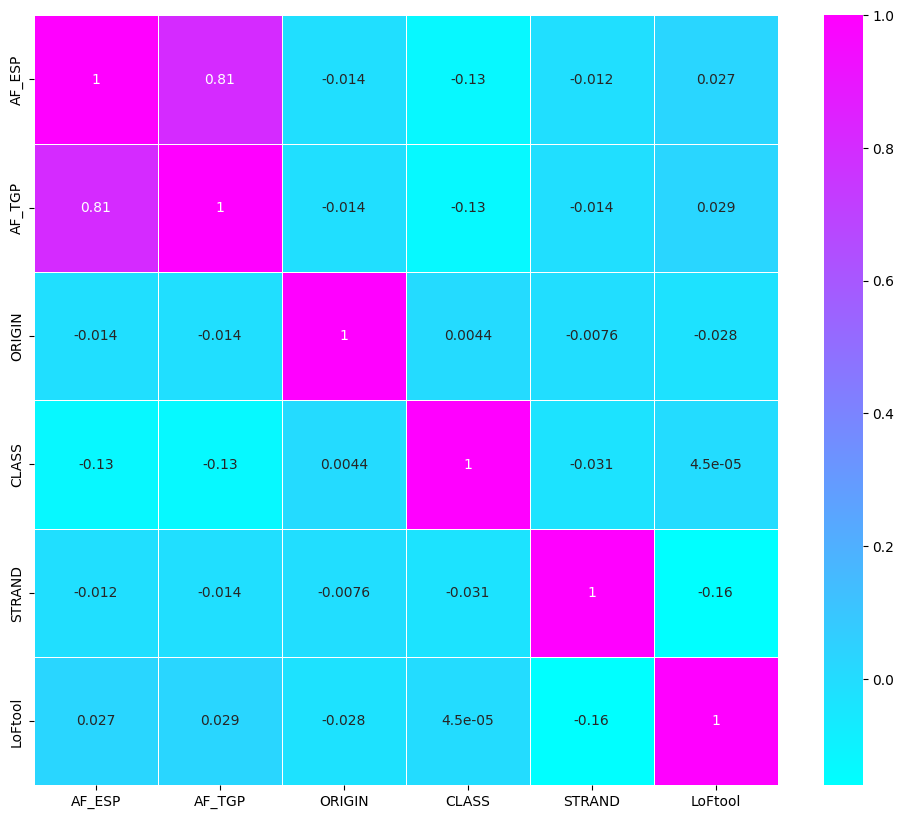

In [10]:
plt.figure(figsize = (12, 10))
sns.heatmap(data.corr(), annot = True, linewidths=.5, cmap = plt.cm.cool)

High correlation between variables, often indicated by coefficients above 0.8 or 0.9, implies redundancy in the information they provide. Specifically, in this scenario, the correlation between AF_ESP (Allele frequencies from GO-ESP) and AF_TGP (Allele frequencies from the 1000 Genomes Project) exceeds 0.8, indicating significant similarity in the information they convey. 
<br>Removing the AF_TGP column helps mitigate redundancy and potential multicollinearity issues, streamlining the dataset for more efficient analyses or models.

In [11]:
data.drop(['AF_TGP'],axis = 1, inplace=True)
data.columns

Index(['CHROM', 'REF', 'ALT', 'AF_ESP', 'CLNVC', 'MC', 'ORIGIN', 'CLASS',
       'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature_type', 'Feature',
       'BIOTYPE', 'EXON', 'Amino_acids', 'Codons', 'STRAND', 'LoFtool'],
      dtype='object')

## Feature Transformation
Feature transformation encompasses actions like handling missing values, such as removing null values from columns or replacing them with the mean, median, or mode of the respective feature. Additionally, it involves scaling numerical features, encoding categorical variables, and creating new features to enhance the dataset's quality and readiness for analysis or modeling.

In [12]:
# Check for null values and their types
null_counts = data.isnull().sum()
null_columns = null_counts[null_counts != 0].index
null_data = data[null_columns]

null_data.head()

,MC,SYMBOL,Feature_type,Feature,BIOTYPE,EXON,Amino_acids,Codons,STRAND,LoFtool
0,SO:0001583|missense_variant,B3GALT6,Transcript,NM_080605.3,protein_coding,1/1,E/D,gaG/gaC,1.0,NaN
1,SO:0001583|missense_variant,TMEM240,Transcript,NM_001114748.1,protein_coding,4/4,P/L,cCg/cTg,-1.0,NaN
2,"SO:0001583|missense_variant,SO:0001623|5_prime...",GNB1,Transcript,NM_002074.4,protein_coding,6/12,I/T,aTc/aCc,-1.0,NaN
3,SO:0001583|missense_variant,SKI,Transcript,XM_005244775.1,protein_coding,1/7,G/S,Ggc/Agc,1.0,NaN
4,SO:0001583|missense_variant,SKI,Transcript,XM_005244775.1,protein_coding,1/7,G/C,Ggc/Tgc,1.0,NaN


In [13]:
null_data.dtypes

MC               object
SYMBOL           object
Feature_type     object
Feature          object
BIOTYPE          object
EXON             object
Amino_acids      object
Codons           object
STRAND          float64
LoFtool         float64
dtype: object

Replace missing values (NaN) in the categorical columns **MC, SYMBOL, Feature_type, Feature, BIOTYPE, Amino_acids, Codons, and STRAND** with the most frequent value. This ensures that these categorical features remain representative and do not introduce bias into the analysis or modeling process.
<br>Replace missing values in the numerical column **LoFtool** with the mean. By doing so, we preserve the overall distribution of the data while ensuring that missing values are filled with a reasonable estimate based on the available information.

In [14]:
# Replacing missing values with mode
categorical_columns = ["MC", "SYMBOL", "Feature_type", "Feature", "BIOTYPE", "STRAND", "Amino_acids", "Codons"]
for column in categorical_columns:
    most_frequent_value = data[column].mode()[0]
    data[column].fillna(most_frequent_value, inplace=True)

# Replacing missing values with the mean
mean_loftool = data['LoFtool'].mean()
data['LoFtool'].fillna(mean_loftool, inplace=True)

# Check for remaining null values
data.isnull().sum()

CHROM              0
REF                0
ALT                0
AF_ESP             0
CLNVC              0
MC                 0
ORIGIN             0
CLASS              0
Allele             0
Consequence        0
IMPACT             0
SYMBOL             0
Feature_type       0
Feature            0
BIOTYPE            0
EXON            8893
Amino_acids        0
Codons             0
STRAND             0
LoFtool            0
dtype: int64

Identify variable types based on unique values: categorical for qualitative data, numerical for quantitative, binary for yes/no, and ordinal for ranked data. Segregate variables for tailored preprocessing and analysis techniques.

In [15]:
# Extract columns with object type
df_object = data.select_dtypes(include='object')

# Count unique values for each column
df_uniques = pd.DataFrame([[column, len(df_object[column].unique())] 
                           for column in df_object.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
CHROM,38
REF,866
ALT,458
CLNVC,7
MC,90
Allele,374
Consequence,48
IMPACT,4
SYMBOL,2328


In [16]:
binary_features = list(df_uniques[df_uniques['Unique Values'] == 2].index)
categorical_features = list(df_uniques[(df_uniques['Unique Values'] > 2)].index)

print("Binary Features : ",binary_features,"\nCategorical Features : ",categorical_features)

Binary Features :  ['Feature_type', 'BIOTYPE'] 
Categorical Features :  ['CHROM', 'REF', 'ALT', 'CLNVC', 'MC', 'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature', 'EXON', 'Amino_acids', 'Codons']


In [17]:
# Convert categorical features to string type
for column in categorical_features:
    data[column] = data[column].astype(str)

# Check data types of categorical features
print(data[categorical_features].dtypes)

CHROM          object
REF            object
ALT            object
CLNVC          object
MC             object
Allele         object
Consequence    object
IMPACT         object
SYMBOL         object
Feature        object
EXON           object
Amino_acids    object
Codons         object
dtype: object


In [18]:
numeric_features = list(set(data.columns) - set(categorical_features) - set(binary_features))
data[numeric_features].dtypes

AF_ESP     float64
CLASS        int64
LoFtool    float64
ORIGIN       int64
STRAND     float64
dtype: object

In [19]:
# Initialize LabelBinarizer and LabelEncoder
lb = LabelBinarizer()
le = LabelEncoder()

# Encode ordinal variables using LabelEncoder
for col in categorical_features:
    data[col] = le.fit_transform(data[col])

# Encode binary variables using LabelBinarizer
for col in binary_features:
    data[col] = lb.fit_transform(data[col])

In [20]:
data.sample(3)

,CHROM,REF,ALT,AF_ESP,CLNVC,MC,ORIGIN,CLASS,Allele,Consequence,IMPACT,SYMBOL,Feature_type,Feature,BIOTYPE,EXON,Amino_acids,Codons,STRAND,LoFtool
53216,17,0,213,0.0,6,89,1,0,168,46,1,140,1,2318,1,569,748,1291,1.0,0.00386
16994,3,224,335,0.0,6,19,1,0,296,17,2,16,1,1493,1,1433,905,1167,-1.0,0.04770
20156,4,644,106,0.0,6,19,1,0,88,17,2,248,1,22,1,181,690,817,1.0,0.08960


<Axes: >

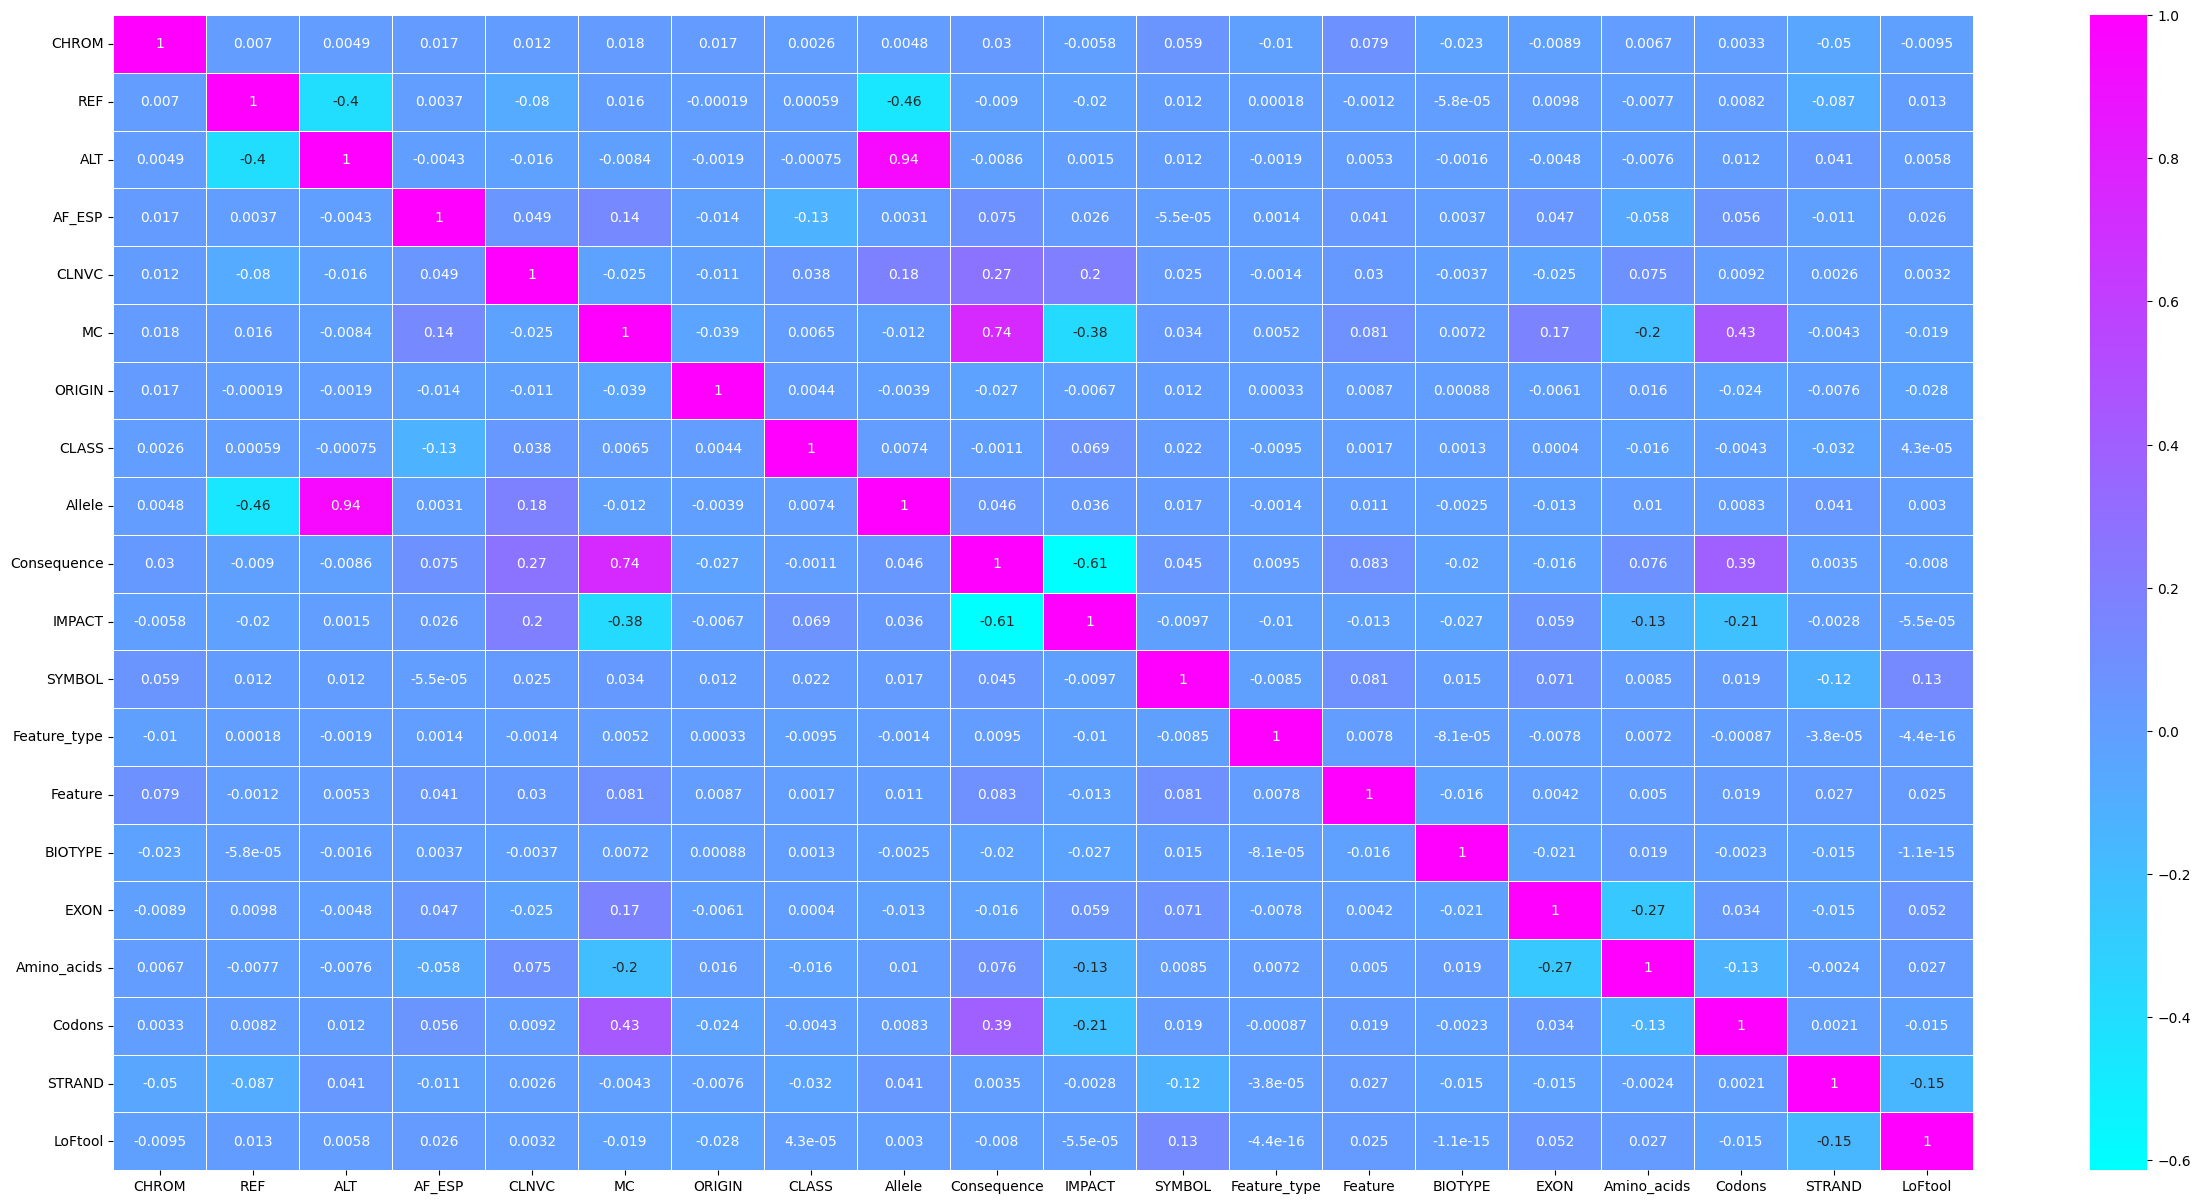

In [21]:
plt.figure(figsize = (30, 15))
sns.heatmap(data.corr(), annot = True, linewidths=.5, cmap = plt.cm.cool)

Due to high correlations above 0.8, we're dropping the **ALT** and **MC** columns to avoid redundancy and potential multicollinearity issues in the dataset.

In [22]:
data = data.drop(columns=["ALT", "MC"])

# Removing 'ALT' and 'MC'
categorical_features = [feature for feature in categorical_features if feature not in ['ALT', 'MC']]

We're utilizing MinMaxScaler to scale the data to a specific range, ensuring all features are on a consistent scale. This normalization helps improve model performance, particularly for algorithms sensitive to feature magnitudes and distances, such as KNN or SVM. Additionally, by saving the processed dataset separately, we streamline future analysis, eliminating the need for repeated data cleaning and preprocessing.

In [23]:
# Initialize MinMaxScaler
mm = MinMaxScaler()

# Scale features using MinMaxScaler
for column in categorical_features + numeric_features:
    data[column] = mm.fit_transform(data[[column]])

# Save processed dataset to CSV
data.to_csv('clinvar_processed_dataset.csv', index=False)

## Splitting data in train and test set
We're splitting the data into training and testing sets using StratifiedShuffleSplit, which preserves the same class ratio in both sets. The 'class' column is excluded from the training dataset as it represents the target variable to be predicted.

In [24]:
data = pd.read_csv('./clinvar_processed_dataset.csv', sep=',')
features = list(data.columns)
features.remove('CLASS')

In [25]:
# Split the data into train and test sets
shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=38)
train_data, test_data = next(shuf_split.split(data[features], data.CLASS))

# Create train and test dataframes
trainX, trainY = data.loc[train_data, features], data.loc[train_data, 'CLASS']
testX, testY = data.loc[test_data, features], data.loc[test_data, 'CLASS']

# Check the lengths of train and test sets
len(testX), len(trainX)

(13038, 52150)

## Training Classification models
Utilize the k-nearest neighbors algorithm, decision tree, and random forest classifiers to analyze the data. Visualize the model performance using heatmaps and compare their scores across multiple metrics, including precision, recall, accuracy, F1 score, and area under the ROC curve (AUC). This comparative assessment offers insights into the effectiveness of different classifiers in predicting the target outcome.

<ul>
    <li><h3>K-nearest Neighbors</h3></li>
</ul>

In [26]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=3, weights='distance').fit(trainX, trainY)
pred_knn = knn.predict(testX)

# Calculating metrics
knn_precision, knn_recall = round(precision_score(testY, pred_knn, average='weighted'), 2),round(recall_score(testY, pred_knn, average='weighted'), 2)
knn_accuracy = round(accuracy_score(testY, pred_knn), 2)
knn_f1score = round(f1_score(testY, pred_knn), 2)
knn_auc = round(roc_auc_score(testY, pred_knn), 2)

# Creating KNN stats dataframe
knn_stats = pd.DataFrame({'Precision': knn_precision,
                          'Recall': knn_recall,
                          'Accuracy': knn_accuracy,
                          'F1 Score': knn_f1score,
                          'AUC': knn_auc}, index=['KNN'])
knn_stats

,Precision,Recall,Accuracy,F1 Score,AUC
KNN,0.66,0.68,0.68,0.3,0.55


<ul>
    <li><h3>Decision Tree</h3></li>
</ul>

In [27]:
# Estimate Decision Tree model and report outcomes
dt = DecisionTreeClassifier(random_state=38).fit(trainX, trainY)
pred_dt = dt.predict(testX)

# Calculating metrics
dt_precision = round(precision_score(testY, pred_dt, average='weighted'), 2)
dt_recall = round(recall_score(testY, pred_dt, average='weighted'), 2)
dt_accuracy = round(accuracy_score(testY, pred_dt), 2)
dt_f1score = round(f1_score(testY, pred_dt), 2)
dt_auc = round(roc_auc_score(testY, pred_dt), 2)

# Creating Decision Tree stats dataframe
dt_stats = pd.DataFrame({'Precision': dt_precision,
                         'Recall': dt_recall,
                         'Accuracy': dt_accuracy,
                         'F1 Score': dt_f1score,
                         'AUC': dt_auc}, index=['Decision Tree'])
dt_stats

,Precision,Recall,Accuracy,F1 Score,AUC
Decision Tree,0.69,0.68,0.68,0.38,0.58


<ul>
    <li><h3>Logistic Regression</h3></li>
</ul>

In [28]:
# Estimate Logistic Regression model and report outcomes
lr = LogisticRegression(random_state=38).fit(trainX, trainY)
pred_lr = lr.predict(testX)

# Calculating metrics
lr_precision = round(precision_score(testY, pred_lr, average='weighted'), 2)
lr_recall = round(recall_score(testY, pred_lr, average='weighted'), 2)
lr_accuracy = round(accuracy_score(testY, pred_lr), 2)
lr_f1score = round(f1_score(testY, pred_lr), 2)
lr_auc = round(roc_auc_score(testY, pred_lr), 2)

# Creating Logistic Regression stats dataframe
lr_stats = pd.DataFrame({'Precision': lr_precision,
                         'Recall': lr_recall,
                         'Accuracy': lr_accuracy,
                         'F1 Score': lr_f1score,
                         'AUC': lr_auc}, index=['Logistic Regression'])
lr_stats

,Precision,Recall,Accuracy,F1 Score,AUC
Logistic Regression,0.65,0.75,0.75,0.0,0.5


<ul>
    <li><h3>Random Forest</h3></li>
</ul>

[Text(0, 0.5, 'Out-of-Bag Error')]

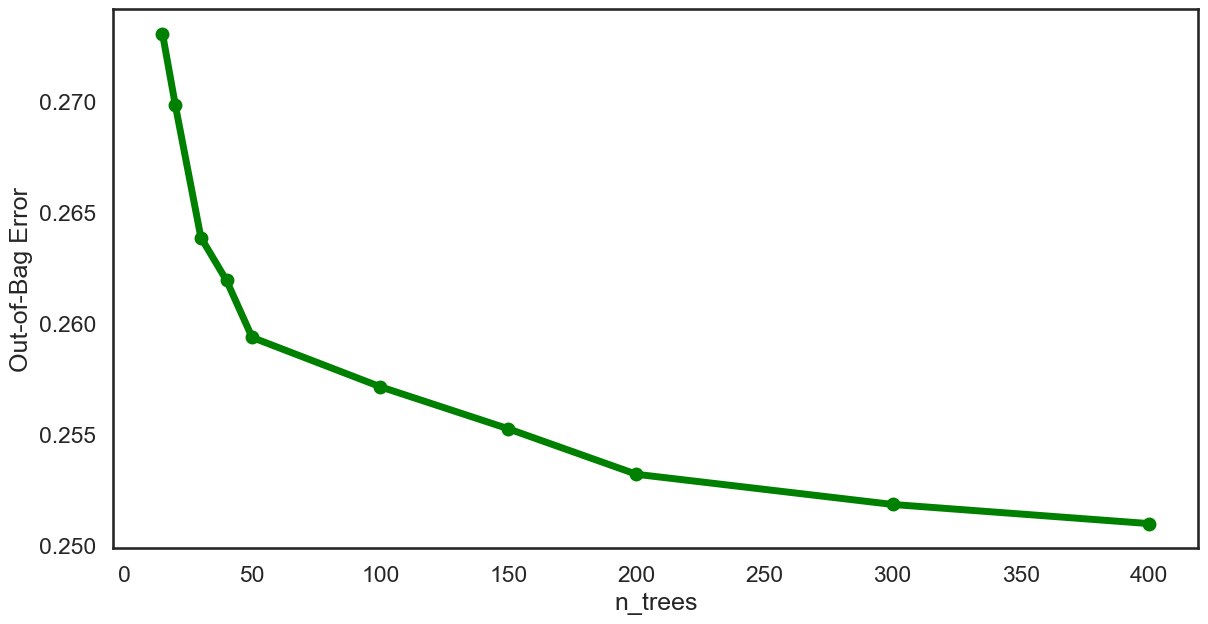

In [29]:
rf = RandomForestClassifier(oob_score=True, random_state=38, warm_start=True, n_jobs=-1)
oob_list = []
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    rf.set_params(n_estimators=n_trees).fit(trainX, trainY)
    oob_error = 1 - rf.oob_score_
    oob_list.append({'n_trees': n_trees, 'oob': oob_error})
rf_oob_df = pd.DataFrame(oob_list).set_index('n_trees')

# Set seaborn context and style
sns.set_context('talk')
sns.set_style('white')

# Plot out-of-bag error
ax = rf_oob_df.plot(legend=False, marker='o', color="green", figsize=(14, 7), linewidth=5)
ax.set(ylabel='Out-of-Bag Error')

Based on the elbow method, it appears that the error stabilizes around **200 trees**. Therefore, we select 200 as the number of estimators (n_estimators) for the model.

In [30]:
# Set random forest parameters
rf = rf.set_params(n_estimators=200)

# Predict using random forest model
pred_rf = rf.predict(testX)

# Calculate metrics
rf_precision, rf_recall = round(precision_score(testY, pred_rf, average='weighted'), 2), round(recall_score(testY, pred_rf, average='weighted'), 2)
rf_accuracy = round(accuracy_score(testY, pred_rf), 2)
rf_f1score = round(f1_score(testY, pred_rf), 2)
rf_auc = round(roc_auc_score(testY, pred_rf), 2)

# Create random forest stats dataframe
rf_stats = pd.DataFrame({'Precision': rf_precision,
                         'Recall': rf_recall,
                         'Accuracy': rf_accuracy,
                         'F1 Score': rf_f1score,
                         'AUC': rf_auc}, index=['Random Forest'])
rf_stats

,Precision,Recall,Accuracy,F1 Score,AUC
Random Forest,0.71,0.74,0.74,0.33,0.58


## Comparing Results

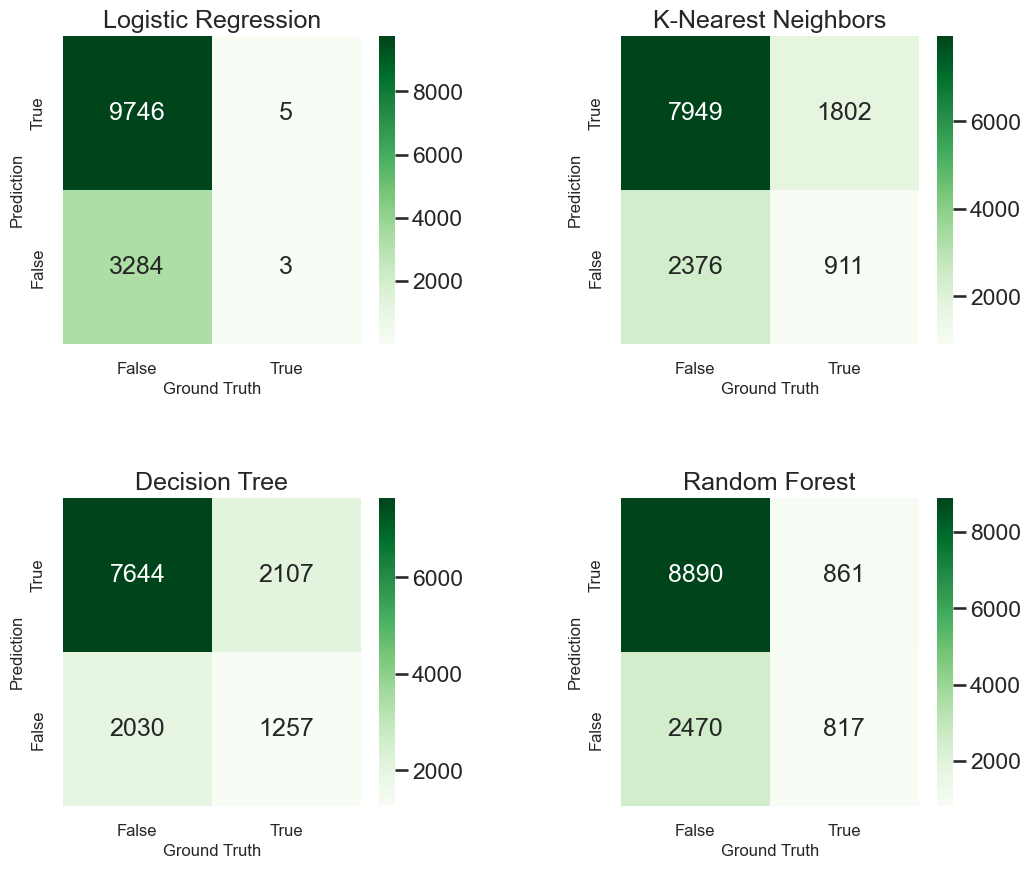

In [31]:
fig, axList = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axList = axList.flatten()
fig.set_size_inches(12, 10)
models = ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Random Forest']
conf_matrices = [confusion_matrix(testY, pred_lr),
                 confusion_matrix(testY, pred_knn),
                 confusion_matrix(testY, pred_dt),
                 confusion_matrix(testY, pred_rf)]
labels = ['False', 'True']

for ax, model, cm in zip(axList, models, conf_matrices):
    sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap='Greens')
    ax.set(title=model)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels(labels[::-1], fontsize=12)
    ax.set_ylabel('Prediction', fontsize=12)
    ax.set_xlabel('Ground Truth', fontsize=12)

In [32]:
# Generating classification reports for all models
report_lr = pd.DataFrame(classification_report(testY, pred_lr, output_dict=True)).iloc[:3, :2]
report_rf = pd.DataFrame(classification_report(testY, pred_rf, output_dict=True)).iloc[:3, :2]
report_dt = pd.DataFrame(classification_report(testY, pred_dt, output_dict=True)).iloc[:3, :2]
report_knn = pd.DataFrame(classification_report(testY, pred_knn, output_dict=True)).iloc[:3, :2]

# Combining reports into a single DataFrame
model_reports = pd.concat([report_lr, report_rf, report_dt, report_knn], axis=1)
model_reports.columns = ['Precision_LR', 'Recall_LR',
                          'Precision_RF', 'Recall_RF',
                          'Precision_DT', 'Recall_DT',
                          'Precision_KNN', 'Recall_KNN']

# Displaying the combined report
model_reports

,Precision_LR,Recall_LR,Precision_RF,Recall_RF,Precision_DT,Recall_DT,Precision_KNN,Recall_KNN
precision,0.747966,0.375000,0.782570,0.486889,0.790159,0.373662,0.769879,0.335791
recall,0.999487,0.000913,0.911701,0.248555,0.783920,0.382416,0.815198,0.277152
f1-score,0.855625,0.001821,0.842215,0.329104,0.787027,0.377988,0.791891,0.303667


## Conclusion
Looking at the results, the Random Forest (RF) model demonstrates the highest precision (0.782) and recall (0.249), indicating its ability to make accurate **positive predictions** and capture positive instances effectively. Additionally, the F1-score for RF (0.842) is relatively high, indicating a good balance between precision and recall.
Comparatively, logistic regression (LR) shows relatively high precision (0.748) but very low recall (0.001), resulting in a low F1-score (0.856). Decision Tree (DT) and K-nearest neighbors (KNN) also exhibit lower F1-scores compared to RF.

Therefore, based on these metrics, the Random Forest model appears to be the most suitable for genetic variation detection, as it achieves a good balance between precision and recall, resulting in a high F1-score.

## Future Developments
Future developments for this project could include exploring more advanced machine learning algorithms, such as **gradient boosting machines or neural networks**, to potentially improve model performance. Additionally, incorporating domain-specific features or leveraging external datasets could enhance the predictive power of the models. Furthermore, implementing techniques like **ensemble** learning or model **stacking** could be beneficial for combining the strengths of multiple models. Finally, continuous monitoring and updating of the models with new data could ensure that they remain accurate and relevant over time.